[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23714
[LightGBM] [Info] Number of data points in the train set: 4364, number of used features: 93
[LightGBM] [Info] Start training from score 0.028185
Optimal Threshold: 0.3421
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1060
           1       0.56      0.48      0.52        31

    accuracy                           0.97      1091
   macro avg       0.77      0.74      0.75      1091
weighted avg       0.97      0.97      0.97      1091

Precision-Recall AUC: 0.5093


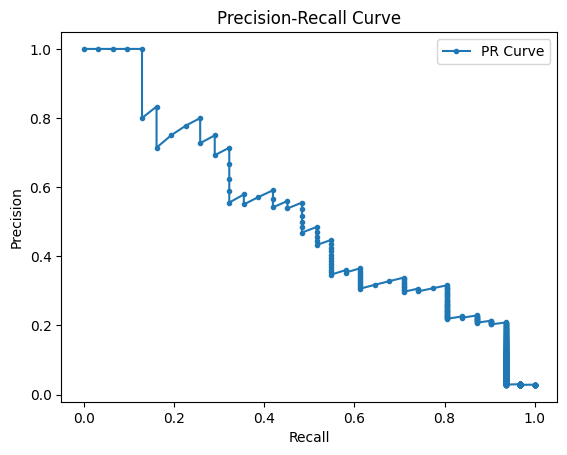

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, auc

# Load dataset
df = pd.read_csv("Train.csv")  # Replace with actual dataset path

# Split target and features
y = df.iloc[:, 0]   # Target variable (0 = Non-bankrupt, 1 = Bankrupt)
X = df.iloc[:, 1:]  # Features

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# *Step 1: Use Regression Instead of Classification*
# Train a Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
gbr.fit(X_train, y_train)

# Train a LightGBM Regressor
lgbm = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
lgbm.fit(X_train, y_train)

# *Step 2: Combine Predictions from Both Models*
y_pred_gbr = gbr.predict(X_test)
y_pred_lgbm = lgbm.predict(X_test)

# *Averaging Predictions for Better Performance*
y_pred_prob = (y_pred_gbr + y_pred_lgbm) / 2

# *Step 3: Find the Best Decision Threshold Using Precision-Recall Curve*
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]  # Optimal threshold based on best F1 score

# *Step 4: Convert Probabilities to Binary Predictions*
y_pred = (y_pred_prob >= best_threshold).astype(int)

# *Evaluation*
print(f"Optimal Threshold: {best_threshold:.4f}")
print(classification_report(y_test, y_pred))

# *Precision-Recall AUC*
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

# *Plot Precision-Recall Curve*
plt.plot(recall, precision, marker='.', label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()